In [1]:
!pip install -q kaggle
from google.colab import files

files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"rkkhaerul","key":"93d98ddfe0d5f08e768fc9e1e5f2a435"}'}

In [2]:
!mkdir ~/.kaggle
!mv kaggle.json ~/.kaggle
!chmod 600 ~/.kaggle/kaggle.json


In [3]:
!kaggle datasets list -s 'Brain Tumor Classification (MRI)'

ref                                                         title                                            size  lastUpdated          downloadCount  voteCount  usabilityRating  
----------------------------------------------------------  ----------------------------------------------  -----  -------------------  -------------  ---------  ---------------  
sartajbhuvaji/brain-tumor-classification-mri                Brain Tumor Classification (MRI)                 87MB  2020-05-24 16:24:55          65915        690  0.875            
jarvisgroot/brain-tumor-classification-mri-images           Brain Tumor Classification MRI Images           633MB  2021-07-04 21:21:38           1792         44  0.9375           
masoudnickparvar/brain-tumor-mri-dataset                    Brain Tumor MRI Dataset                         149MB  2021-09-24 12:43:45          72816        664  0.875            
ahmedhamada0/brain-tumor-detection                          Br35H :: Brain Tumor Detection 2020     

In [4]:
!kaggle datasets download -d 'sartajbhuvaji/brain-tumor-classification-mri'

Dataset URL: https://www.kaggle.com/datasets/sartajbhuvaji/brain-tumor-classification-mri
License(s): MIT
 99% 86.0M/86.8M [00:00<00:00, 242MB/s]
100% 86.8M/86.8M [00:00<00:00, 220MB/s]


In [5]:
import zipfile,os,shutil

In [6]:
fileZip = "brain-tumor-classification-mri.zip"
extracZip = zipfile.ZipFile(fileZip, 'r')
extracZip.extractall("datasets")

In [7]:
os.listdir("/content/datasets")

['Training', 'Testing']

In [8]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import cv2
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tqdm import tqdm
import os
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, TensorBoard, ModelCheckpoint
from sklearn.metrics import classification_report,confusion_matrix
import ipywidgets as widgets
import io
from PIL import Image
from IPython.display import display,clear_output
from warnings import filterwarnings
for dirname, _, filenames in os.walk('/content/datasets'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

/content/datasets/Training/glioma_tumor/gg (769).jpg
/content/datasets/Training/glioma_tumor/gg (153).jpg
/content/datasets/Training/glioma_tumor/gg (100).jpg
/content/datasets/Training/glioma_tumor/gg (515).jpg
/content/datasets/Training/glioma_tumor/gg (532).jpg
/content/datasets/Training/glioma_tumor/gg (478).jpg
/content/datasets/Training/glioma_tumor/gg (160).jpg
/content/datasets/Training/glioma_tumor/gg (79).jpg
/content/datasets/Training/glioma_tumor/gg (12).jpg
/content/datasets/Training/glioma_tumor/gg (374).jpg
/content/datasets/Training/glioma_tumor/gg (247).jpg
/content/datasets/Training/glioma_tumor/gg (349).jpg
/content/datasets/Training/glioma_tumor/gg (171).jpg
/content/datasets/Training/glioma_tumor/gg (339).jpg
/content/datasets/Training/glioma_tumor/gg (31).jpg
/content/datasets/Training/glioma_tumor/gg (4).jpg
/content/datasets/Training/glioma_tumor/gg (619).jpg
/content/datasets/Training/glioma_tumor/gg (614).jpg
/content/datasets/Training/glioma_tumor/gg (397).jp

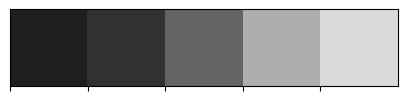

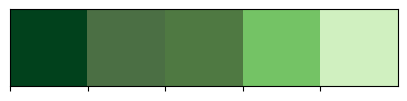

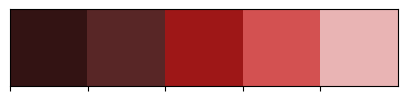

In [13]:
colors_dark = ["#1F1F1F", "#313131", '#636363', '#AEAEAE', '#DADADA']
colors_red = ["#331313", "#582626", '#9E1717', '#D35151', '#E9B4B4']
colors_green = ['#01411C','#4B6F44','#4F7942','#74C365','#D0F0C0']

sns.palplot(colors_dark)
sns.palplot(colors_green)
sns.palplot(colors_red)

Dictionary

In [9]:
labels = ['glioma_tumor','no_tumor','meningioma_tumor','pituitary_tumor']


In [10]:
labels[1]

'no_tumor'

PreProcessing

In [14]:
X_train = []
y_train = []
image_size = 150
for i in labels:
    folderPath = os.path.join('../content/datasets','Training',i)
    for j in tqdm(os.listdir(folderPath)):
        img = cv2.imread(os.path.join(folderPath,j))
        img = cv2.resize(img,(image_size, image_size))
        X_train.append(img)
        y_train.append(i)

for i in labels:
    folderPath = os.path.join('../content/datasets','Testing',i)
    for j in tqdm(os.listdir(folderPath)):
        img = cv2.imread(os.path.join(folderPath,j))
        img = cv2.resize(img,(image_size,image_size))
        X_train.append(img)
        y_train.append(i)

X_train = np.array(X_train)
y_train = np.array(y_train)

100%|██████████| 74/74 [00:00<00:00, 197.99it/s]


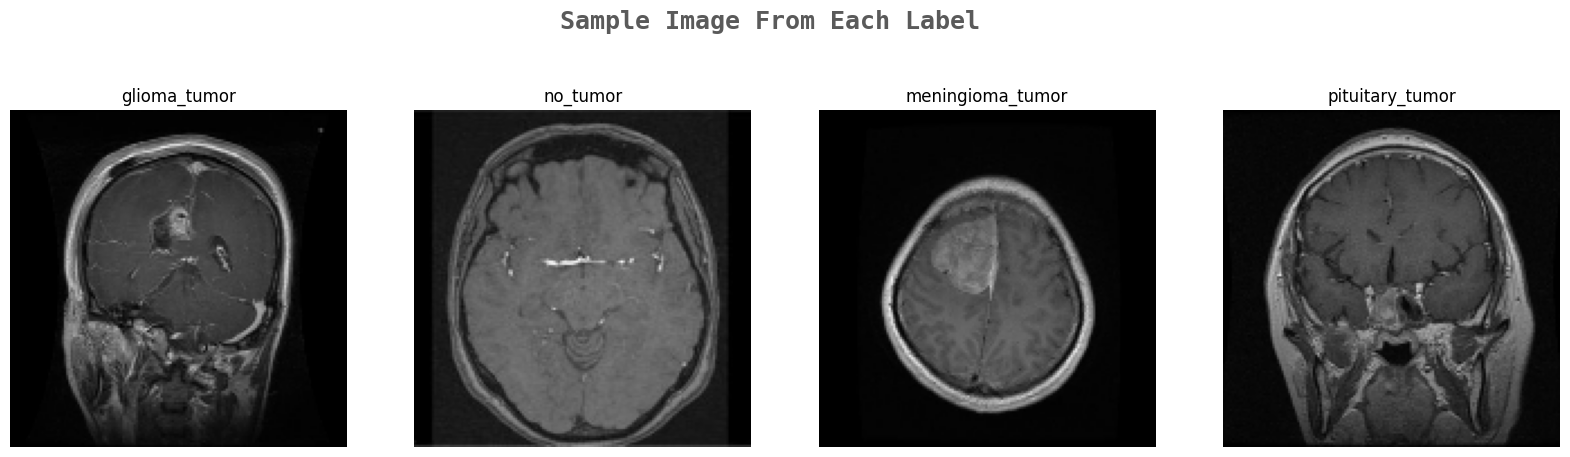

In [15]:
k=0
fig, ax = plt.subplots(1,4,figsize=(20,20))
fig.text(s='Sample Image From Each Label',size=18,fontweight='bold',
             fontname='monospace',color=colors_dark[1],y=0.62,x=0.4,alpha=0.8)
for i in labels:
    j=0
    while True :
        if y_train[j]==i:
            ax[k].imshow(X_train[j])
            ax[k].set_title(y_train[j])
            ax[k].axis('off')
            k+=1
            break
        j+=1

Shuffle dan Split Data
Data diacak dan dibagi menjadi data pelatihan dan pengujian untuk memastikan pembagian data

In [16]:
X_train, y_train = shuffle(X_train,y_train, random_state=101)

In [17]:
X_train.shape

(3264, 150, 150, 3)

In [18]:
y_train.shape

(3264,)

Augmentasi Data
Data augmentasi digunakan untuk meningkatkan variasi data pelatihan dan membantu mengurangi overfitting:

In [19]:
datagen = ImageDataGenerator(
    rotation_range=30,
    width_shift_range=0.1,
    height_shift_range=0.1,
    zoom_range=0.2,
    horizontal_flip=True)

datagen.fit(X_train)
X_train.shape

(3264, 150, 150, 3)

Shuffle dan Split Data
Data diacak dan dibagi menjadi data pelatihan dan pengujian untuk memastikan pembagian data

In [20]:
X_train,X_test,y_train,y_test = train_test_split(X_train,y_train, test_size=0.2,random_state=101)

In [21]:
y_test.shape


(653,)

In [22]:
y_train.shape

(2611,)

In [23]:
y_train_new = []
for i in y_train:
    y_train_new.append(labels.index(i))
y_train = y_train_new
y_train = tf.keras.utils.to_categorical(y_train)


y_test_new = []
for i in y_test:
    y_test_new.append(labels.index(i))
y_test = y_test_new
y_test = tf.keras.utils.to_categorical(y_test)

In [24]:
effnet = EfficientNetB0(weights='imagenet',include_top=False,input_shape=(image_size,image_size,3))

16705208/16705208 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


Model CNN with effnet

In [25]:
model = effnet.output
model = tf.keras.layers.GlobalAveragePooling2D()(model)
model = tf.keras.layers.Dropout(rate=0.5)(model)
model = tf.keras.layers.Dense(4,activation='softmax')(model)
model = tf.keras.models.Model(inputs=effnet.input, outputs = model)

In [26]:
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)  │ (None, 150, 150, 3)    │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ rescaling (Rescaling)     │ (None, 150, 150, 3)    │              0 │ input_layer[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ normalization             │ (None, 150, 150, 3)    │              7 │ rescaling[0][0]        │
│ (Normalization)           │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ rescaling_1 (Rescaling)   │ (None, 150, 150, 3)    │              0 │ normalization[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ stem_conv_pad             │ (None, 151, 151, 3)    │              0 │ rescaling_1[0][0]      │
│ (ZeroPadding2D)           │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ stem_conv (Conv2D)        │ (None, 75, 75, 32)     │            864 │ stem_conv_pad[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ stem_bn                   │ (None, 75, 75, 32)     │            128 │ stem_conv[0][0]        │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ stem_activation           │ (None, 75, 75, 32)     │              0 │ stem_bn[0][0]          │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1a_dwconv            │ (None, 75, 75, 32)     │            288 │ stem_activation[0][0]  │
│ (DepthwiseConv2D)         │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1a_bn                │ (None, 75, 75, 32)     │            128 │ block1a_dwconv[0][0]   │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1a_activation        │ (None, 75, 75, 32)     │              0 │ block1a_bn[0][0]       │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1a_se_squeeze        │ (None, 32)             │              0 │ block1a_activation[0]… │
│ (GlobalAveragePooling2D)  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1a_se_reshape        │ (None, 1, 1, 32)       │              0 │ block1a_se_squeeze[0]… │
│ (Reshape)                 │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1a_se_reduce         │ (None, 1, 1, 8)        │            264 │ block1a_se_reshape[0]… │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1a_se_expand    

 Total params: 4,054,695 (15.47 MB)

 Trainable params: 4,012,672 (15.31 MB)

 Non-trainable params: 42,023 (164.16 KB)

Optimasi Adam

In [27]:
model.compile(loss='categorical_crossentropy',optimizer = 'Adam', metrics= ['accuracy'])

In [28]:
tensorboard = TensorBoard(log_dir = 'logs')
checkpoint = ModelCheckpoint("effnet.keras", monitor="val_accuracy", save_best_only=True, mode="auto", verbose=1)
reduce_lr = ReduceLROnPlateau(monitor = 'val_accuracy', factor = 0.3, patience = 2, min_delta = 0.001,
                              mode='auto',verbose=1)

## Training Data ##

In [29]:
history = model.fit(X_train,y_train,validation_split=0.1, epochs =12, verbose=1, batch_size=32,
                   callbacks=[tensorboard,checkpoint,reduce_lr])

Epoch 1/12
74/74 ━━━━━━━━━━━━━━━━━━━━ 0s 4s/step - accuracy: 0.7281 - loss: 0.6876
Epoch 1: val_accuracy improved from -inf to 0.82824, saving model to effnet.keras
74/74 ━━━━━━━━━━━━━━━━━━━━ 371s 4s/step - accuracy: 0.7294 - loss: 0.6849 - val_accuracy: 0.8282 - val_loss: 0.5513 - learning_rate: 0.0010
Epoch 2/12
74/74 ━━━━━━━━━━━━━━━━━━━━ 0s 4s/step - accuracy: 0.9337 - loss: 0.1872
Epoch 2: val_accuracy did not improve from 0.82824
74/74 ━━━━━━━━━━━━━━━━━━━━ 384s 4s/step - accuracy: 0.9336 - loss: 0.1875 - val_accuracy: 0.5115 - val_loss: 1.7945 - learning_rate: 0.0010
Epoch 3/12
74/74 ━━━━━━━━━━━━━━━━━━━━ 0s 4s/step - accuracy: 0.9501 - loss: 0.1432
Epoch 3: val_accuracy did not improve from 0.82824

Epoch 3: ReduceLROnPlateau reducing learning rate to 0.0003000000142492354.
74/74 ━━━━━━━━━━━━━━━━━━━━ 377s 4s/step - accuracy: 0.9501 - loss: 0.1432 - val_accuracy: 0.6794 - val_loss: 1.5779 - learning_rate: 0.0010
Epoch 4/12
74/74 ━━━━━━━━━━━━━━━━━━━━ 0s 4s/step - accuracy: 0.9712 - 

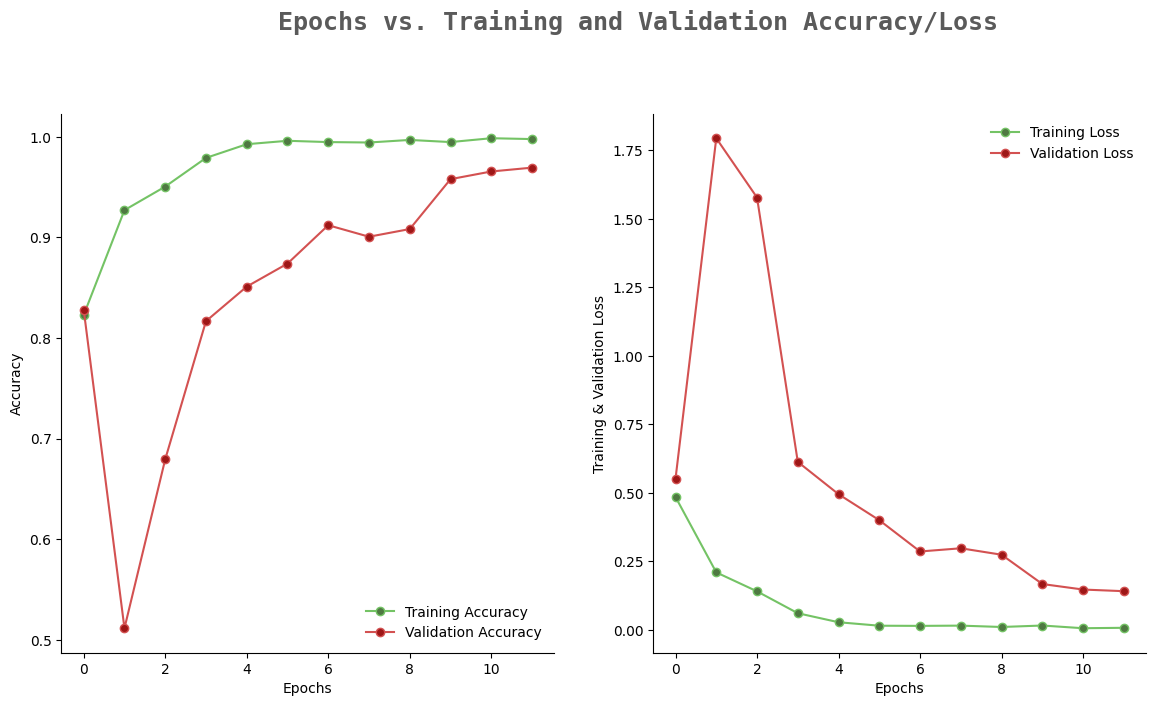

In [30]:
filterwarnings('ignore')

epochs = [i for i in range(12)]
fig, ax = plt.subplots(1,2,figsize=(14,7))
train_acc = history.history['accuracy']
train_loss = history.history['loss']
val_acc = history.history['val_accuracy']
val_loss = history.history['val_loss']

fig.text(s='Epochs vs. Training and Validation Accuracy/Loss',size=18,fontweight='bold',
             fontname='monospace',color=colors_dark[1],y=1,x=0.28,alpha=0.8)

sns.despine()
ax[0].plot(epochs, train_acc, marker='o',markerfacecolor=colors_green[2],color=colors_green[3],
           label = 'Training Accuracy')
ax[0].plot(epochs, val_acc, marker='o',markerfacecolor=colors_red[2],color=colors_red[3],
           label = 'Validation Accuracy')
ax[0].legend(frameon=False)
ax[0].set_xlabel('Epochs')
ax[0].set_ylabel('Accuracy')

sns.despine()
ax[1].plot(epochs, train_loss, marker='o',markerfacecolor=colors_green[2],color=colors_green[3],
           label ='Training Loss')
ax[1].plot(epochs, val_loss, marker='o',markerfacecolor=colors_red[2],color=colors_red[3],
           label = 'Validation Loss')
ax[1].legend(frameon=False)
ax[1].set_xlabel('Epochs')
ax[1].set_ylabel('Training & Validation Loss')

fig.show()

In [31]:
pred = model.predict(X_test)
pred = np.argmax(pred,axis=1)
y_test_new = np.argmax(y_test,axis=1)

21/21 ━━━━━━━━━━━━━━━━━━━━ 27s 1s/step


In [32]:
print(classification_report(y_test_new,pred))

              precision    recall  f1-score   support

           0       0.98      0.96      0.97       168
           1       0.96      0.99      0.98       108
           2       0.99      0.97      0.98       201
           3       0.97      1.00      0.99       176

    accuracy                           0.98       653
   macro avg       0.98      0.98      0.98       653
weighted avg       0.98      0.98      0.98       653



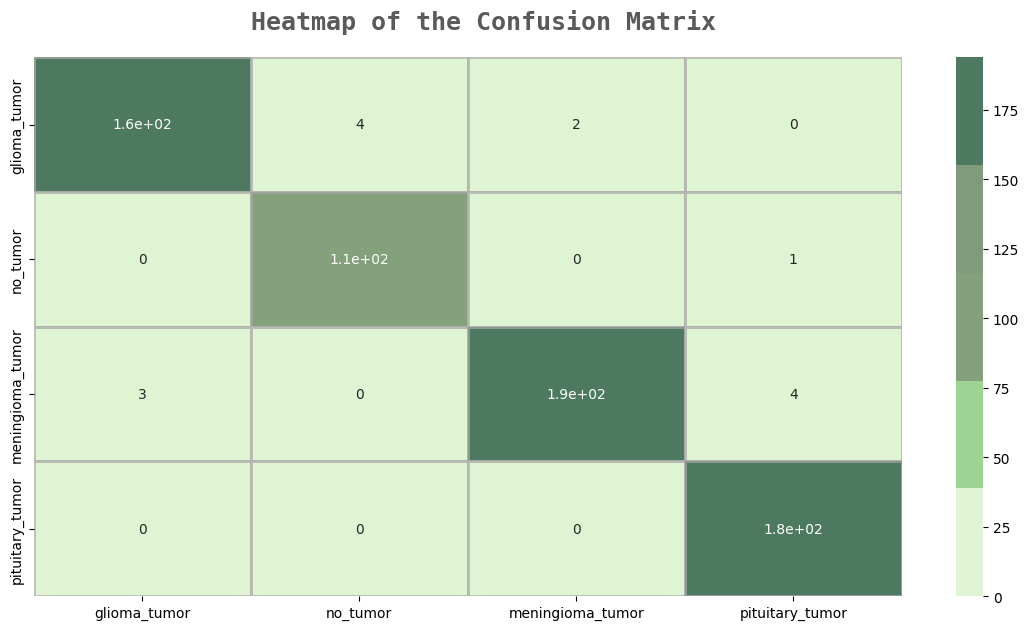

In [33]:
fig,ax=plt.subplots(1,1,figsize=(14,7))
sns.heatmap(confusion_matrix(y_test_new,pred),ax=ax,xticklabels=labels,yticklabels=labels,annot=True,
           cmap=colors_green[::-1],alpha=0.7,linewidths=2,linecolor=colors_dark[3])
fig.text(s='Heatmap of the Confusion Matrix',size=18,fontweight='bold',
             fontname='monospace',color=colors_dark[1],y=0.92,x=0.28,alpha=0.8)

plt.show()

In [34]:
def img_pred(upload):
    for name, file_info in uploader.value.items():
        img = Image.open(io.BytesIO(file_info['content']))
    opencvImage = cv2.cvtColor(np.array(img), cv2.COLOR_RGB2BGR)
    img = cv2.resize(opencvImage,(150,150))
    img = img.reshape(1,150,150,3)
    p = model.predict(img)
    p = np.argmax(p,axis=1)[0]

    if p==0:
        p='Glioma Tumor'
    elif p==1:
        print('The model predicts that there is no tumor')
    elif p==2:
        p='Meningioma Tumor'
    else:
        p='Pituitary Tumor'

    if p!=1:
        print(f'The Model predicts that it is a {p}')

In [35]:
button = widgets.Button(description='Predict')
out = widgets.Output()
def on_button_clicked(_):
    with out:
        clear_output()
        try:
            img_pred(uploader)

        except:
            print('No Image Uploaded/Invalid Image File')




In [38]:
uploader = widgets.FileUpload()
display(uploader)


FileUpload(value={}, description='Upload')

In [39]:
button.on_click(on_button_clicked)
widgets.VBox([button,out])